<div style='background-image: url("../../share/images/header.svg") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 250px'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">LaTeX, R y Julia - I</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Ulises M. Alvarez</div>
        </div>
    </div>
</div>

# Prerequisistos de sistema operativo

* En OpenBSD: gdal
* En Debian:  libgdal-dev

# Librerías de R

In [1]:
options(repos = "https://cloud.r-project.org")      # Definimos repositorio 
if (!require("pacman")) install.packages("pacman")  # Si no tenemos, pacman, lo instalamos

# Un año de sismos

## Generando el mapa

Para generar el mapa, necesitaremos las siguientes librerías:

In [2]:
pacman::p_load(rgeos, 
               maptools, 
               rgdal, 
               ggplot2, 
               ggthemes, 
               ggalt, 
               mapproj)

También es necesario descargar tres 'shapefiles' de:

* http://rud.is/dl/quakefiles.tgz 


In [3]:
# El globo terraqueo 
world <- readOGR("countries.geo.json", 
                 "OGRGeoJSON", 
                 stringsAsFactors = FALSE) 
world <- gBuffer(world, byid = TRUE, width = 0) 
world <- nowrapRecenter(world) 

OGR data source with driver: GeoJSON 
Source: "countries.geo.json", layer: "OGRGeoJSON"
with 180 features
It has 2 fields


Warning message in gBuffer(world, byid = TRUE, width = 0):
“Spatial object is not projected; GEOS expects planar coordinates”

In [4]:
# Las placas                                                                                        
plates <- readOGR("plates.json", "OGRGeoJSON", 
                  stringsAsFactors = FALSE)                                                           
plates <- nowrapRecenter(plates) 

OGR data source with driver: GeoJSON 
Source: "plates.json", layer: "OGRGeoJSON"
with 12 features
It has 2 fields


In [5]:
# Se define funcion() para manipular las coordenadas                                                
# y recentrar el mapa en la placa del Pacifico
recenter_points <- function (obj) {
    crds  <- coordinates(obj) 
    inout <- (crds[, 1] < 0) 
    if (all(inout)) { crds[, 1] <- crds[, 1] + 360 }
    else { 
        if (any(inout)) { crds[, 1] <- 
                         ifelse(inout, crds[, 1] + 360, crds[, 1]) } }
    SpatialPointsDataFrame(crds, obj@data)    
}

In [6]:
# Se agregan las coordenadas de los sismos
quakes <- readOGR("quakes.json", "OGRGeoJSON", 
                  stringsAsFactors = FALSE)                                                          
quakes <- recenter_points(quakes)  

OGR data source with driver: GeoJSON 
Source: "quakes.json", layer: "OGRGeoJSON"
with 1183 features
It has 27 fields
Integer64 fields read as strings:  time updated 


In [7]:
# Se genera el mapa                                                                                 
world_map        <- fortify(world)                                                                  
plates_map       <- fortify(plates)                                                                 
quakes_dat       <- data.frame(quakes)                                                              
quakes_dat$trans <- quakes_dat$mag %% 5

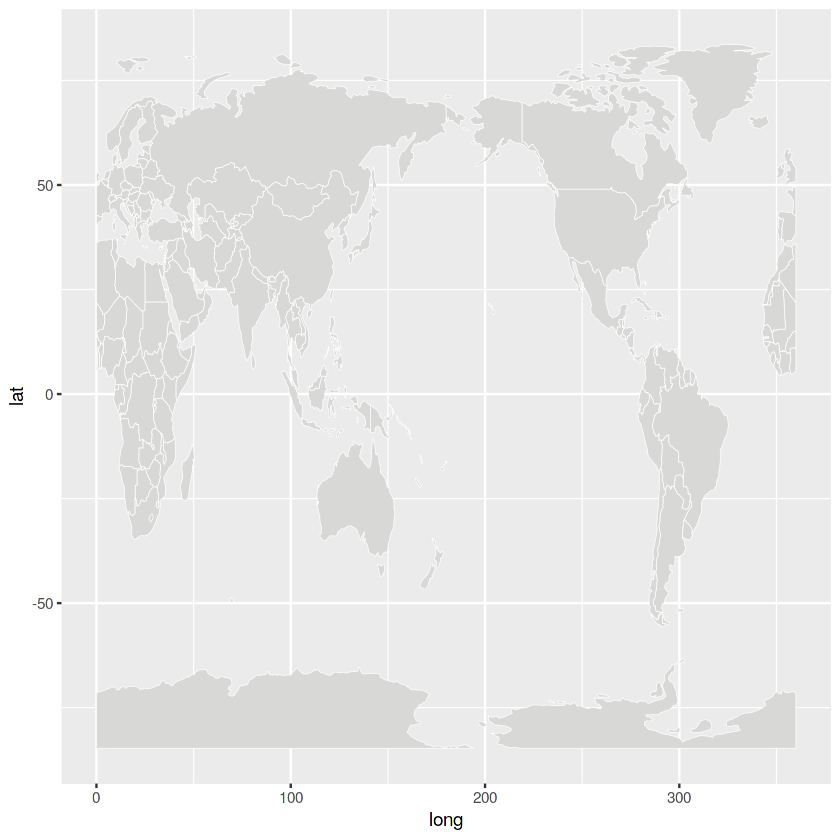

In [8]:
gg <- ggplot()  # Inicializamos el mapa como objeto, gg
gg <- gg + geom_cartogram(data  = world_map, 
                          map   = world_map, 
                          aes(x = long, 
                              y = lat, map_id = id), 
                          color = "white", 
                          size  = 0.15, 
                          fill  = "#d8d8d6") 

gg              # Mostramos el resultado

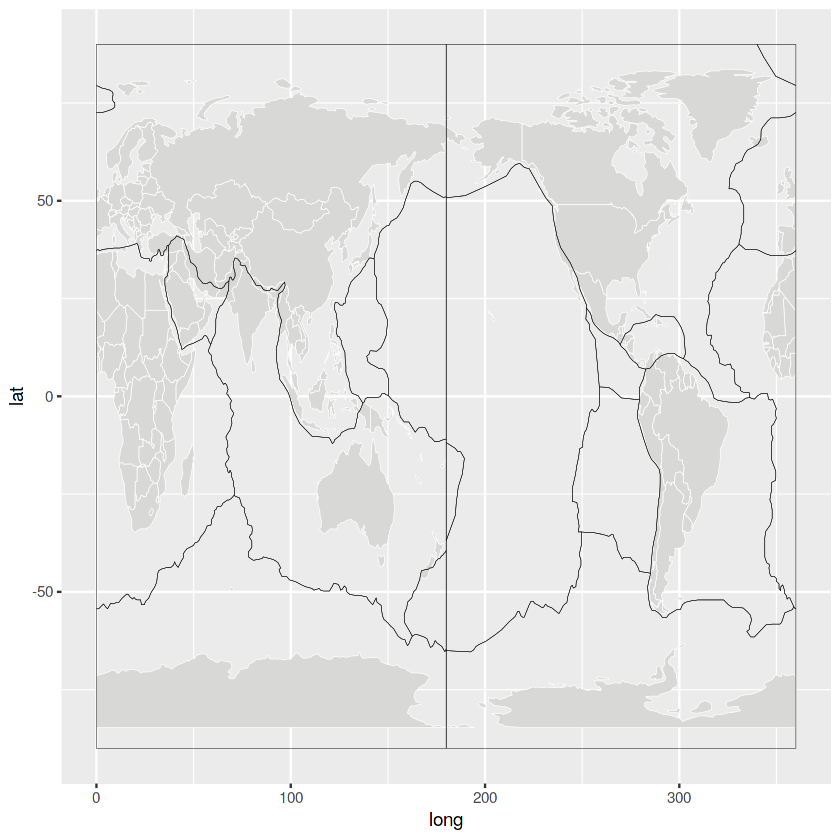

In [9]:
gg <- gg + geom_cartogram(data  = plates_map, map = plates_map, 
                          aes(x = long, y = lat, map_id = id), 
                          color = "black", size = 0.1, 
                          fill  = "#00000000", alpha = 0)

gg              # Mostramos el resultado

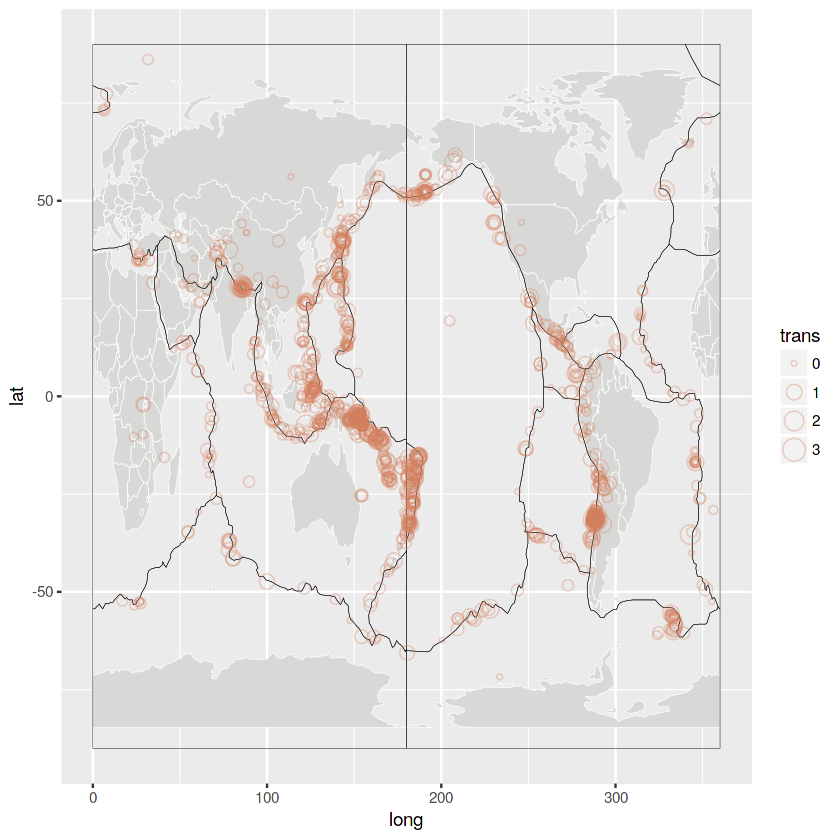

In [10]:
gg <- gg + geom_point(data  = quakes_dat, 
                      aes(x = coords.x1, y = coords.x2, size = trans), 
                      shape = 1, 
                      alpha = 1/3, 
                      color = "#d47e5d", 
                      fill  = "#00000000")

gg              # Mostramos el resultado

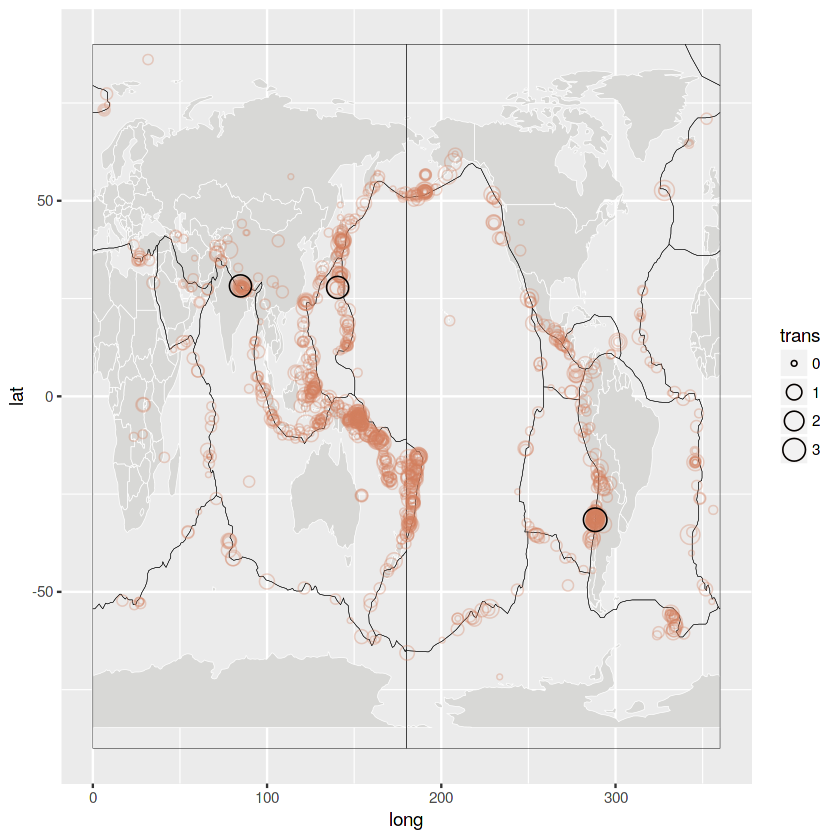

In [11]:
gg <- gg + geom_point(data  = subset(quakes_dat, mag > 7.5), 
                      aes(x = coords.x1, y = coords.x2, size = trans), 
                      shape = 1, alpha = 1, color = "black", 
                      fill  = "#00000000")

gg              # Mostramos el resultado

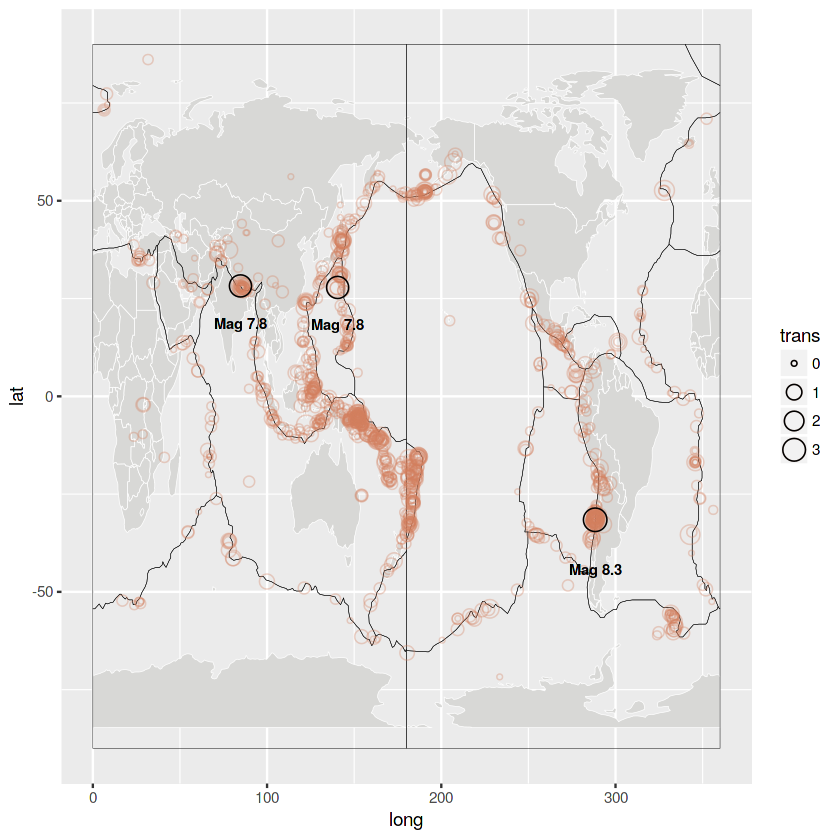

In [12]:
gg <- gg + geom_text(data  = subset(quakes_dat, mag > 7.5),                                      
                     aes(x = coords.x1, y = coords.x2,
                         label = sprintf("Mag %2.1f", mag)),                                         
                     color     = "black", 
                     size      = 3, 
                     vjust     = c(3.9, 3.9, 5),                          
                     fontface  = "bold") 

gg              # Mostramos el resultado

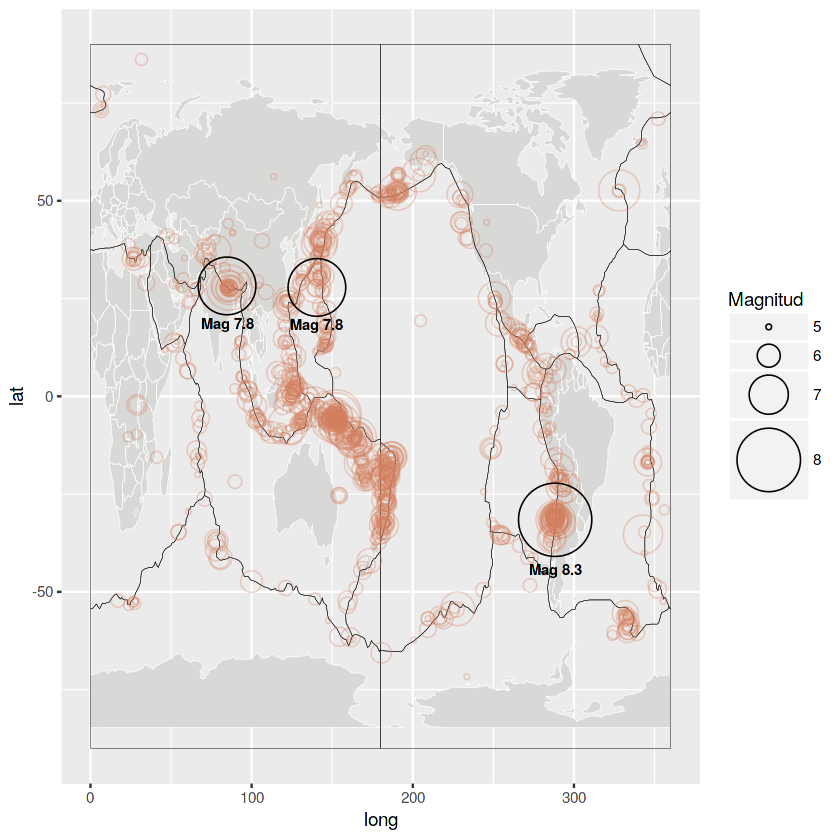

In [13]:
gg <- gg + scale_size(name   = "Magnitud",                                                          
                      trans  = "exp",                                                               
                      labels = c(5:8),                                                              
                      range  = c(1, 20))

gg              # Mostramos el resultado

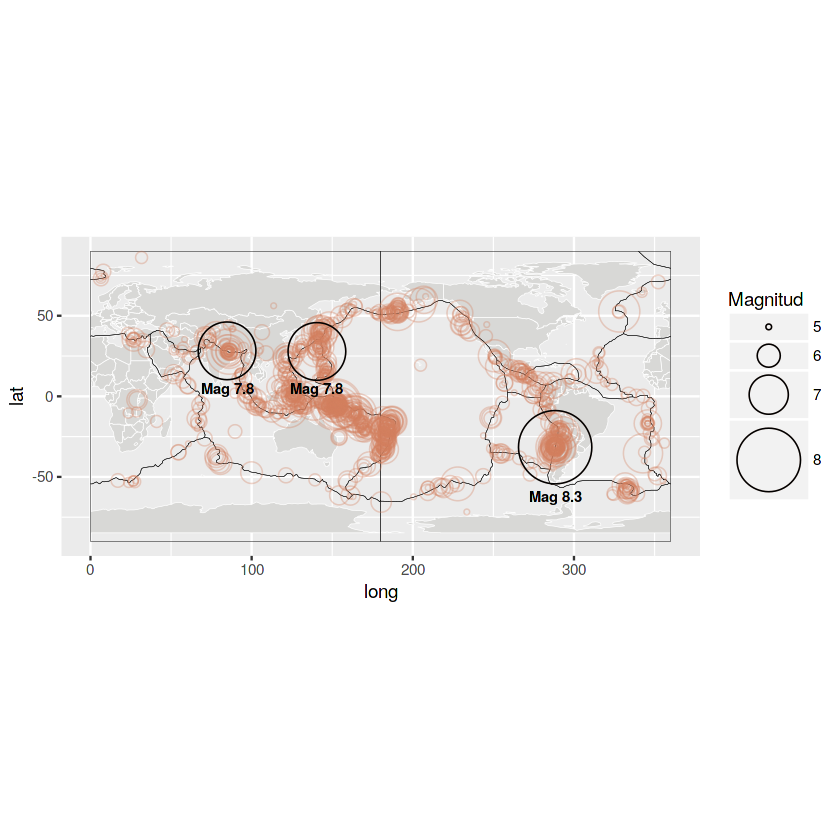

In [14]:
gg <- gg + coord_quickmap()

gg              # Mostramos el resultado

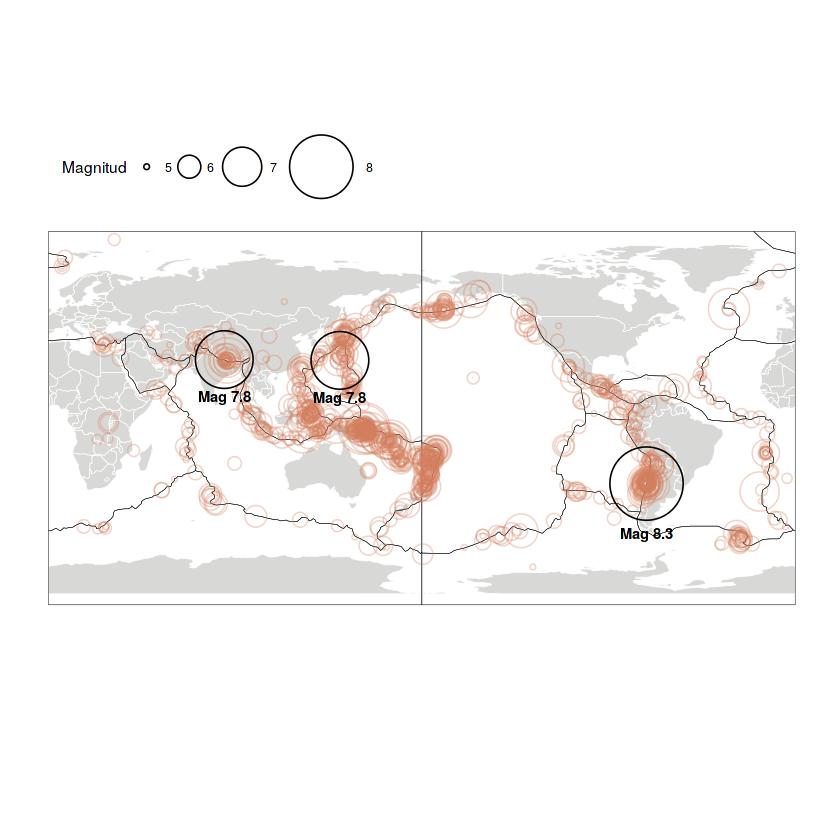

In [15]:
gg <- gg + theme_map()                                                                              
gg <- gg + theme(legend.position  = c(0.05, 0.99))                                                  
gg <- gg + theme(legend.direction = "horizontal")                                                   
gg <- gg + theme(legend.key       = element_rect(color="#00000000"))

gg              # Mostramos el resultado

## Downloading and Visualizing Seismic Events from USGS

https://www.r-bloggers.com/cluster-analysis-on-earthquake-data-from-usgs/

In [16]:
pacman::p_load(sp,
               raster,
               plotrix,
               rgeos, 
               rgdal)
#               scatterplot3d)

In [17]:
URL <- "http://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_month.csv"
Earthquake_30Days <- read.table(URL, sep = ",", header = T)

Warning message in file(file, "rt"):
“"internal" method cannot handle https redirection to: 'https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_month.csv'”Warning message in file(file, "rt"):
“"internal" method failed, so trying "libcurl"”

In [18]:
#Download, unzip and load the polygon shapefile with the countries' borders
download.file("http://thematicmapping.org/downloads/TM_WORLD_BORDERS_SIMPL-0.3.zip",destfile="TM_WORLD_BORDERS_SIMPL-0.3.zip")
unzip("TM_WORLD_BORDERS_SIMPL-0.3.zip",exdir=getwd())
polygons <- shapefile("TM_WORLD_BORDERS_SIMPL-0.3.shp")

In [19]:
dir.create(paste(getwd(),"/GeologicalData",sep=""))

Warning message in dir.create(paste(getwd(), "/GeologicalData", sep = "")):
“'/home/uma/ownCloud/notebooks/Rstats/tallerJuR/GeologicalData' already exists”

In [20]:
#Faults
download.file("http://legacy.jefferson.kctcs.edu/techcenter/gis%20data/World/Zip/FAULTS.zip",destfile="GeologicalData/FAULTS.zip")
unzip("GeologicalData/FAULTS.zip",exdir="GeologicalData")
 
# faults <- shapefile("GeologicalData/FAULTS.SHP")  # Does not work!

faults <- readOGR("GeologicalData/FAULTS.SHP") 

Warning message in ogrInfo(dsn = dsn, layer = layer, encoding = encoding, use_iconv = use_iconv, :
“ogrInfo: /home/uma/ownCloud/notebooks/Rstats/tallerJuR/GeologicalData/FAULTS.dbf not found”

OGR data source with driver: ESRI Shapefile 
Source: "GeologicalData/FAULTS.SHP", layer: "FAULTS"
with 4441 features
It has 1 fields


In [21]:
#Plates
download.file("http://legacy.jefferson.kctcs.edu/techcenter/gis%20data/World/Zip/PLAT_LIN.zip",destfile="GeologicalData/plates.zip")
unzip("GeologicalData/plates.zip",exdir="GeologicalData")
 
# plates <- shapefile("GeologicalData/PLAT_LIN.SHP")
plates <- readOGR("GeologicalData/PLAT_LIN.SHP")

Warning message in ogrInfo(dsn = dsn, layer = layer, encoding = encoding, use_iconv = use_iconv, :
“ogrInfo: /home/uma/ownCloud/notebooks/Rstats/tallerJuR/GeologicalData/PLAT_LIN.dbf not found”

OGR data source with driver: ESRI Shapefile 
Source: "GeologicalData/PLAT_LIN.SHP", layer: "PLAT_LIN"
with 51 features
It has 1 fields


In [22]:
#Volcano
download.file("http://legacy.jefferson.kctcs.edu/techcenter/gis%20data/World/Zip/VOLCANO.zip",destfile="GeologicalData/VOLCANO.zip")
unzip("GeologicalData/VOLCANO.zip",exdir="GeologicalData")
 
# volcano <- shapefile("GeologicalData/VOLCANO.SHP")
volcano <- readOGR("GeologicalData/VOLCANO.SHP")

Warning message in ogrInfo(dsn = dsn, layer = layer, encoding = encoding, use_iconv = use_iconv, :
“ogrInfo: /home/uma/ownCloud/notebooks/Rstats/tallerJuR/GeologicalData/VOLCANO.dbf not found”

OGR data source with driver: ESRI Shapefile 
Source: "GeologicalData/VOLCANO.SHP", layer: "VOLCANO"
with 915 features
It has 5 fields


In [23]:
Earthquakes <- Earthquake_30Days[paste(Earthquake_30Days$type)=="earthquake",]
coordinates(Earthquakes)=~longitude+latitude

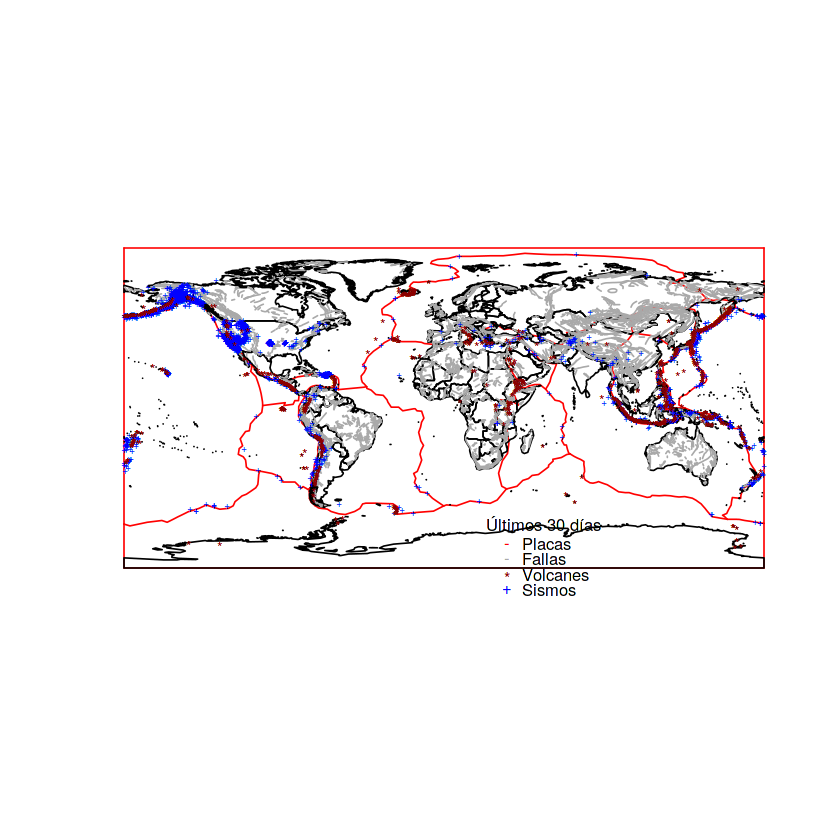

In [24]:
# jpeg("Earthquake_Origin.jpg",4000,2000,res=300)
plot(plates, col = "red")
plot(polygons, add = T)
# title("Earthquakes in the last 30 days",cex.main=3)
lines(faults,col = "dark grey")
points(Earthquakes, 
       col = "blue",
       cex = 0.5,
       pch = "+")
points(volcano,
       pch = "*",
       cex = 0.7,
       col = "dark red")
legend.pos <- list(x = 20.97727, y = -57.86364)
 
#legend(legend.pos,legend=c("Plates","Faults","Volcanoes","Earthquakes"),pch=c("-","-","*","+"),col=c("red","dark grey","dark red","blue"),bty="n",bg=c("white"),y.intersp=0.75,title="Days from Today",cex=0.8) 
legend(legend.pos,
       legend = c("Placas", "Fallas", "Volcanes", "Sismos"),
       pch    = c("-", "-", "*", "+"),
       col    = c("red", "dark grey", "dark red", "blue"),
       bty    = "n",
       bg     = c("white"),
       y.intersp = 0.75,
       title = "Últimos 30 días",
       cex   = 0.8)  

# text(legend.pos$x, legend.pos$y+2, "Legend:")
# dev.off()

## Introductory Time-Series analysis of US Environmental Protection Agency (EPA) pollution data

https://r-video-tutorial.blogspot.mx/2015/05/introductory-time-series-analysis-of-us.html

### Download EPA air pollution data 

In [25]:
pacman::p_load(sp,
               raster,
               xts)

In [26]:
download.EPA <- function(year,                                                                      
                         property = c("ozone", "so2", "co", "no2",                                  
                                      "pm25.frm", "pm25", "pm10",                                   
                                      "wind", "temp", "pressure",                                   
                                      "dewpoint", "hap", "voc", "lead"),                            
                         type = c("hourly", "daily", "annual")) {
    
    if(property=="ozone"){PROP="44201"}
    if(property=="so2"){PROP="42401"}
    if(property=="co"){PROP="42101"}
    if(property=="no2"){PROP="42602"}
    
    if(property=="pm25.frm"){PROP="88101"}
    if(property=="pm25"){PROP="88502"}
    if(property=="pm10"){PROP="81102"}
 
    if(property=="wind"){PROP="WIND"}
    if(property=="temp"){PROP="TEMP"}
    if(property=="pressure"){PROP="PRESS"}
    if(property=="dewpoint"){PROP="RH_DP"}
    if(property=="hap"){PROP="HAPS"}
    if(property=="voc"){PROP="VOCS"}
    if(property=="lead"){PROP="lead"}
    
    URL <- paste0("http://aqsdr1.epa.gov/aqsweb/aqstmp/airdata/",
                  type,"_",PROP,"_",year,".zip")
    download.file(URL, destfile = paste0(type,"_", 
                                         PROP,"_", year, ".zip"))
    unzip(paste0(type,"_", PROP, "_", year, ".zip"),
          exdir=paste0(getwd()))
    read.table(paste0(type,"_", PROP, "_", year, ".csv"),
               sep=",", header=T)
}

In [27]:
data <- download.EPA(year     = 2016,
                     property = "ozone",
                     type     = "daily")

In [28]:
str(data)

'data.frame':	302942 obs. of  29 variables:
 $ State.Code         : int  1 1 1 1 1 1 1 1 1 1 ...
 $ County.Code        : int  3 3 3 3 3 3 3 3 3 3 ...
 $ Site.Num           : int  10 10 10 10 10 10 10 10 10 10 ...
 $ Parameter.Code     : int  44201 44201 44201 44201 44201 44201 44201 44201 44201 44201 ...
 $ POC                : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Latitude           : num  30.5 30.5 30.5 30.5 30.5 ...
 $ Longitude          : num  -87.9 -87.9 -87.9 -87.9 -87.9 ...
 $ Datum              : Factor w/ 2 levels "NAD83","WGS84": 1 1 1 1 1 1 1 1 1 1 ...
 $ Parameter.Name     : Factor w/ 1 level "Ozone": 1 1 1 1 1 1 1 1 1 1 ...
 $ Sample.Duration    : Factor w/ 1 level "8-HR RUN AVG BEGIN HOUR": 1 1 1 1 1 1 1 1 1 1 ...
 $ Pollutant.Standard : Factor w/ 1 level "Ozone 8-Hour 2008": 1 1 1 1 1 1 1 1 1 1 ...
 $ Date.Local         : Factor w/ 350 levels "2016-01-01","2016-01-02",..: 61 62 63 64 65 66 67 68 69 70 ...
 $ Units.of.Measure   : Factor w/ 1 level "Parts per million": 1 1 1 1 1

In [29]:
locations <- data.frame(ID    = numeric(),
                        LON   = numeric(),
                        LAT   = numeric(),
                        OZONE = numeric(),
                        AQI   = numeric())

In [30]:
for(i in unique(data$Address)){
    dat <- data[data$Address == i, ]
    locations[which(i == unique(data$Address)), ] <- 
    data.frame(which(i == unique(data$Address)),
               unique(dat$Longitude),
               unique(dat$Latitude),
               round(mean(dat$Arithmetic.Mean, na.rm = T), 2),
               round(mean(dat$AQI, na.rm = T), 0))
}

In [31]:
locations$ADDRESS <- unique(data$Address)

In [32]:
coordinates(locations) = ~LON + LAT

In [33]:
projection(locations) = CRS("+init=epsg:4326")

In [34]:
ID = 135
Ozone <- data[paste(data$Address) == 
              unique(data$Address)[ID] & paste(data$Event.Type) =="None",]
 
ADDRESS = "966 W 32ND"
Ozone <- data[paste(data$Address) == 
              ADDRESS & paste(data$Event.Type) == "None", ] 

### Time-Series Analysis

In [35]:
str(Ozone$Date.Local)

 Factor w/ 350 levels "2016-01-01","2016-01-02",..: 91 92 93 94 95 96 97 98 99 100 ...


In [36]:
Ozone$DATE <- as.Date(Ozone$Date.Local)

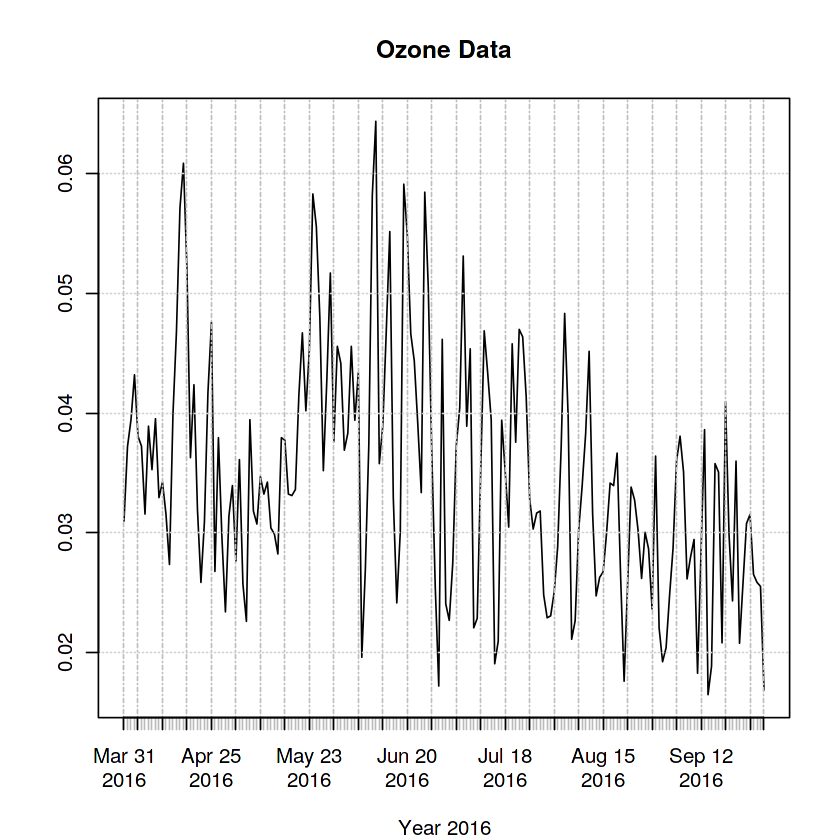

In [37]:
Ozone.TS <- xts(x        = Ozone$Arithmetic.Mean,
                order.by = Ozone$DATE)
plot(Ozone.TS,
     main = "Ozone Data",
     sub  = "Year 2016")

In [38]:
index(Ozone.TS)

[1] "2016-03-31" "2016-04-01" "2016-04-02" "2016-04-03" "2016-04-04"
  [6] "2016-04-05" "2016-04-06" "2016-04-07" "2016-04-08" "2016-04-09"
 [11] "2016-04-10" "2016-04-11" "2016-04-12" "2016-04-13" "2016-04-14"
 [16] "2016-04-15" "2016-04-16" "2016-04-17" "2016-04-18" "2016-04-19"
 [21] "2016-04-20" "2016-04-21" "2016-04-22" "2016-04-23" "2016-04-24"
 [26] "2016-04-25" "2016-04-26" "2016-04-27" "2016-04-28" "2016-04-29"
 [31] "2016-04-30" "2016-05-01" "2016-05-02" "2016-05-03" "2016-05-04"
 [36] "2016-05-05" "2016-05-06" "2016-05-07" "2016-05-08" "2016-05-09"
 [41] "2016-05-10" "2016-05-11" "2016-05-12" "2016-05-13" "2016-05-14"
 [46] "2016-05-15" "2016-05-16" "2016-05-17" "2016-05-18" "2016-05-19"
 [51] "2016-05-20" "2016-05-21" "2016-05-22" "2016-05-23" "2016-05-24"
 [56] "2016-05-25" "2016-05-26" "2016-05-27" "2016-05-28" "2016-05-29"
 [61] "2016-05-30" "2016-05-31" "2016-06-01" "2016-06-02" "2016-06-03"
 [66] "2016-06-04" "2016-06-05" "2016-06-06" "2016-06-07" "2016-06-08"
 [71] "2016-06-09" "2016-06-10" "2016-06-11" "2016-06-12" "2016-06-13"
 [76] "2016-06-14" "2016-06-15" "2016-06-16" "2016-06-17" "2016-06-18"
 [81] "2016-06-19" "2016-06-20" "2016-06-21" "2016-06-22" "2016-06-23"
 [86] "2016-06-24" "2016-06-25" "2016-06-26" "2016-06-27" "2016-06-28"
 [91] "2016-06-29" "2016-06-30" "2016-07-01" "2016-07-02" "2016-07-03"
 [96] "2016-07-04" "2016-07-05" "2016-07-06" "2016-07-07" "2016-07-08"
[101] "2016-07-09" "2016-07-10" "2016-07-11" "2016-07-12" "2016-07-13"
[106] "2016-07-14" "2016-07-15" "2016-07-16" "2016-07-17" "2016-07-18"
[111] "2016-07-19" "2016-07-20" "2016-07-21" "2016-07-22" "2016-07-23"
[116] "2016-07-24" "2016-07-25" "2016-07-26" "2016-07-27" "2016-07-28"
[121] "2016-07-29" "2016-07-30" "2016-07-31" "2016-08-01" "2016-08-02"
[126] "2016-08-03" "2016-08-04" "2016-08-05" "2016-08-06" "2016-08-07"
[131] "2016-08-08" "2016-08-09" "2016-08-10" "2016-08-11" "2016-08-12"
[136] "2016-08-13" "2016-08-14" "2016-08-15" "2016-08-16" "2016-08-17"
[141] "2016-08-18" "2016-08-19" "2016-08-20" "2016-08-21" "2016-08-22"
[146] "2016-08-23" "2016-08-24" "2016-08-25" "2016-08-26" "2016-08-27"
[151] "2016-08-28" "2016-08-29" "2016-08-30" "2016-08-31" "2016-09-01"
[156] "2016-09-02" "2016-09-03" "2016-09-04" "2016-09-05" "2016-09-06"
[161] "2016-09-07" "2016-09-08" "2016-09-09" "2016-09-10" "2016-09-11"
[166] "2016-09-12" "2016-09-13" "2016-09-14" "2016-09-15" "2016-09-16"
[171] "2016-09-17" "2016-09-18" "2016-09-19" "2016-09-20" "2016-09-21"
[176] "2016-09-22" "2016-09-23" "2016-09-24" "2016-09-25" "2016-09-26"
[181] "2016-09-27" "2016-09-28" "2016-09-29" "2016-09-30"

In [39]:
Ozone.TS['2013-05-06'] #Selection of a single day
 
Ozone.TS['2013-03'] #Selection of March data
 
Ozone.TS['2013-05/2013-07'] #Selection by time range

     [,1]

     [,1]

     [,1]

In [40]:
index(Ozone.TS[coredata(Ozone.TS)>0.03,])

[1] "2016-03-31" "2016-04-01" "2016-04-02" "2016-04-03" "2016-04-04"
  [6] "2016-04-05" "2016-04-06" "2016-04-07" "2016-04-08" "2016-04-09"
 [11] "2016-04-10" "2016-04-11" "2016-04-12" "2016-04-14" "2016-04-15"
 [16] "2016-04-16" "2016-04-17" "2016-04-18" "2016-04-19" "2016-04-20"
 [21] "2016-04-21" "2016-04-23" "2016-04-24" "2016-04-25" "2016-04-27"
 [26] "2016-04-30" "2016-05-01" "2016-05-03" "2016-05-06" "2016-05-07"
 [31] "2016-05-08" "2016-05-09" "2016-05-10" "2016-05-11" "2016-05-12"
 [36] "2016-05-15" "2016-05-16" "2016-05-17" "2016-05-18" "2016-05-19"
 [41] "2016-05-20" "2016-05-21" "2016-05-22" "2016-05-23" "2016-05-24"
 [46] "2016-05-25" "2016-05-26" "2016-05-27" "2016-05-28" "2016-05-29"
 [51] "2016-05-30" "2016-05-31" "2016-06-01" "2016-06-02" "2016-06-03"
 [56] "2016-06-04" "2016-06-05" "2016-06-06" "2016-06-09" "2016-06-10"
 [61] "2016-06-11" "2016-06-12" "2016-06-13" "2016-06-14" "2016-06-15"
 [66] "2016-06-16" "2016-06-18" "2016-06-19" "2016-06-20" "2016-06-21"
 [71] "2016-06-22" "2016-06-23" "2016-06-24" "2016-06-25" "2016-06-26"
 [76] "2016-06-27" "2016-06-30" "2016-07-04" "2016-07-05" "2016-07-06"
 [81] "2016-07-07" "2016-07-08" "2016-07-11" "2016-07-12" "2016-07-13"
 [86] "2016-07-14" "2016-07-17" "2016-07-18" "2016-07-19" "2016-07-20"
 [91] "2016-07-21" "2016-07-22" "2016-07-23" "2016-07-24" "2016-07-25"
 [96] "2016-07-26" "2016-07-27" "2016-07-28" "2016-08-03" "2016-08-04"
[101] "2016-08-05" "2016-08-08" "2016-08-09" "2016-08-10" "2016-08-11"
[106] "2016-08-12" "2016-08-16" "2016-08-17" "2016-08-18" "2016-08-19"
[111] "2016-08-23" "2016-08-24" "2016-08-25" "2016-08-27" "2016-08-30"
[116] "2016-09-05" "2016-09-06" "2016-09-07" "2016-09-13" "2016-09-16"
[121] "2016-09-17" "2016-09-19" "2016-09-22" "2016-09-25" "2016-09-26"

In [41]:
apply.weekly(Ozone.TS,FUN=mean)
apply.monthly(Ozone.TS,FUN=max)

                 [,1]
2016-04-03 0.03771850
2016-04-10 0.03623214
2016-04-17 0.04256543
2016-04-24 0.03732143
2016-05-01 0.03296429
2016-05-08 0.03060114
2016-05-15 0.03267857
2016-05-22 0.03802371
2016-05-29 0.04812757
2016-06-05 0.04108929
2016-06-12 0.04079757
2016-06-19 0.04105357
2016-06-26 0.04677971
2016-07-03 0.02856143
2016-07-10 0.03715471
2016-07-17 0.03491657
2016-07-24 0.04054171
2016-07-31 0.02821414
2016-08-07 0.03182743
2016-08-14 0.03288700
2016-08-21 0.02936914
2016-08-28 0.02963286
2016-09-04 0.02505371
2016-09-11 0.03016071
2016-09-18 0.02773800
2016-09-25 0.02979757
2016-09-30 0.02527920

               [,1]
2016-03-31 0.031000
2016-04-30 0.060875
2016-05-31 0.058308
2016-06-30 0.064375
2016-07-31 0.053125
2016-08-31 0.048333
2016-09-30 0.040958

In [42]:
apply.monthly(Ozone.TS,FUN=function(x) {sd(x)/sqrt(length(x))})

                  [,1]
2016-03-31          NA
2016-04-30 0.001608871
2016-05-31 0.001528811
2016-06-30 0.002192840
2016-07-31 0.001705201
2016-08-31 0.001244903
2016-09-30 0.001274180

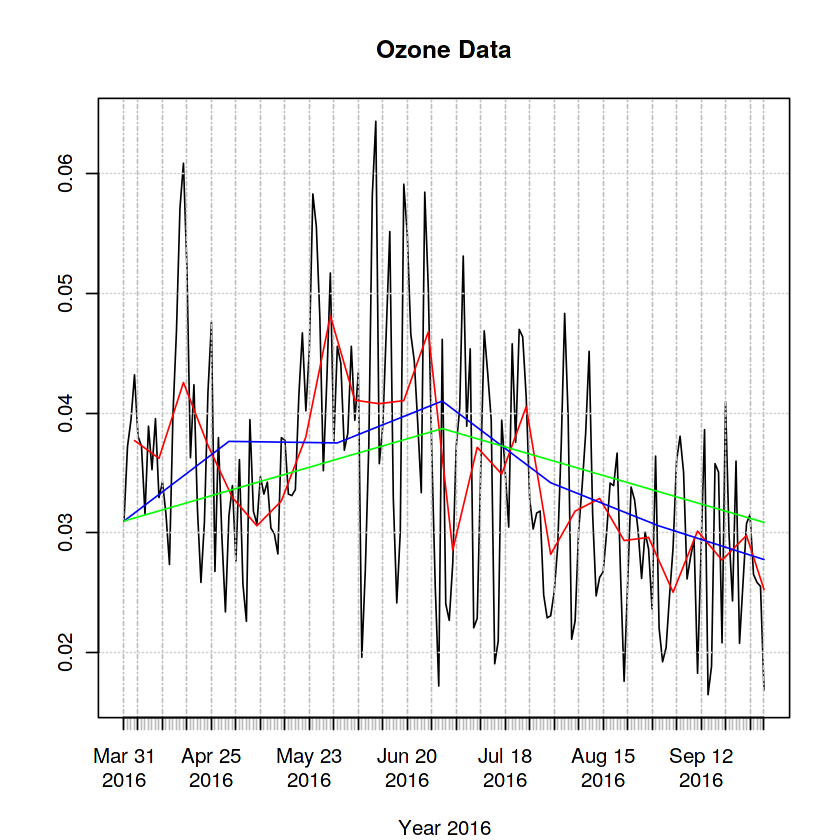

In [43]:
plot(Ozone.TS,
     main = "Ozone Data",
     sub  = "Year 2016")

lines(apply.weekly(Ozone.TS,    FUN = mean),
      col = "red")
lines(apply.monthly(Ozone.TS,   FUN = mean),
      col = "blue")
lines(apply.quarterly(Ozone.TS, FUN = mean),
      col = "green")
lines(apply.yearly(Ozone.TS,    FUN = mean),
      col = "pink")

In [44]:
NO2.2016.DATA <- download.EPA(year=2016,property="no2",type="daily")
NO2.2015.DATA <- download.EPA(year=2015,property="no2",type="daily")
NO2.2014.DATA <- download.EPA(year=2014,property="no2",type="daily")

In [45]:
ADDRESS = "2 miles south of Ouray and south of the White and Green River confluence"  #Copied and pasted from the interactive map
NO2.2016 <- NO2.2016.DATA[paste(NO2.2016.DATA$Address)==ADDRESS&paste(NO2.2016.DATA$Event.Type)=="None",]
NO2.2015 <- NO2.2015.DATA[paste(NO2.2015.DATA$Address)==ADDRESS&paste(NO2.2015.DATA$Event.Type)=="None",]
NO2.2014 <- NO2.2014.DATA[paste(NO2.2014.DATA$Address)==ADDRESS&paste(NO2.2014.DATA$Event.Type)=="None",]
 
 
NO2.TS <- ts(c(NO2.2014$Arithmetic.Mean,
               NO2.2015$Arithmetic.Mean,
               NO2.2016$Arithmetic.Mean),
             frequency = 365,
             start = c(2014, 1))

In [46]:
dec <- decompose(NO2.TS)
plot(dec)

ERROR: Error in decompose(NO2.TS): time series has no or less than 2 periods


In [ ]:
STL <- stl(NO2.TS,"periodic")
plot(STL)

## ropenaq, a breath of fresh air/R

http://ropensci.org/blog/blog/2017/02/21/ropenaq

In [47]:
pacman::p_load(ropenaq,
               import,
               countrycode,
               knitr,
               purrr,
               viridis,
               ggplot2,
               dplyr)

In [48]:
import::from(dplyr, filter)
countries <- aq_countries()
filter(countries, name == "India")

name,code,cities,locations,count
India,IN,95,95,3124627


In [49]:
in_cities <- aq_cities(country = "IN")
filter(in_cities, city == "Hyderabad")

city,country,locations,count,cityURL
Hyderabad,IN,10,189504,Hyderabad


In [50]:
aq_locations(city = "Hyderabad") %>%
  knitr::kable()



|location                                    |city      |country | count|sourceNames        |lastUpdated |firstUpdated |sourceName         | latitude| longitude|pm25 |pm10  |no2   |so2   |o3    |co    |bc    |cityURL   |locationURL                                   |
|:-------------------------------------------|:---------|:-------|-----:|:------------------|:-----------|:------------|:------------------|--------:|---------:|:----|:-----|:-----|:-----|:-----|:-----|:-----|:---------|:---------------------------------------------|
|Bollaram Industrial Area                    |Hyderabad |IN      |    25|CPCB               |1487308500  |1487229300   |CPCB               |       NA|        NA|TRUE |TRUE  |TRUE  |TRUE  |FALSE |TRUE  |FALSE |Hyderabad |Bollaram+Industrial+Area                      |
|Bollaram Industrial Area, Hyderabad - TSPCB |Hyderabad |IN      |  5630|CPCB               |1490375700  |1487310300   |CPCB               |       NA|        NA|TRUE |TRUE  |TRUE  |TRUE  |FALSE 

In [51]:
aq_locations(city = "Hyderabad", parameter = "pm25")

location,city,country,count,sourceNames,lastUpdated,firstUpdated,sourceName,latitude,longitude,pm25,pm10,no2,so2,o3,co,bc,cityURL,locationURL
Bollaram Industrial Area,Hyderabad,IN,5,CPCB,2017-02-17 05:15:00,2017-02-16 07:15:00,CPCB,NA,NA,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,Hyderabad,Bollaram+Industrial+Area
"Bollaram Industrial Area, Hyderabad - TSPCB",Hyderabad,IN,1126,CPCB,2017-03-24 17:15:00,2017-02-17 05:45:00,CPCB,NA,NA,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,Hyderabad,Bollaram+Industrial+Area%2C+Hyderabad+-+TSPCB
ICRISAT Patancheru,Hyderabad,IN,38,CPCB,2017-02-17 05:30:00,2017-02-15 18:30:00,CPCB,NA,NA,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,Hyderabad,ICRISAT+Patancheru
"ICRISAT Patancheru, Hyderabad - TSPCB",Hyderabad,IN,1163,CPCB,2017-03-24 17:00:00,2017-02-17 05:30:00,CPCB,NA,NA,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,Hyderabad,ICRISAT+Patancheru%2C+Hyderabad+-+TSPCB
"IDA Pashamylaram,Hyderabad",Hyderabad,IN,11,CPCB,2016-09-20 09:45:00,2016-09-20 04:45:00,CPCB,NA,NA,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,Hyderabad,IDA+Pashamylaram%2CHyderabad
"IDA Pashamylaram, Hyderabad - TSPCB",Hyderabad,IN,8020,CPCB,2017-03-24 17:30:00,2016-09-20 10:15:00,CPCB,NA,NA,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,Hyderabad,IDA+Pashamylaram%2C+Hyderabad+-+TSPCB
Sanathnagar - Hyderabad - TSPCB,Hyderabad,IN,1593,CPCB,2017-03-24 17:30:00,2017-02-18 18:30:00,CPCB,17.42330,78.47470,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,Hyderabad,Sanathnagar+-+Hyderabad+-+TSPCB
TSPCBPashamylaram,Hyderabad,IN,35,CPCB,2016-09-20 04:45:00,2016-09-18 18:30:00,CPCB,NA,NA,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,Hyderabad,TSPCBPashamylaram
US Diplomatic Post: Hyderabad,Hyderabad,IN,11071,StateAir_Hyderabad,2017-03-24 17:30:00,2015-12-11 21:30:00,StateAir_Hyderabad,17.38405,78.45636,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,Hyderabad,US+Diplomatic+Post%3A+Hyderabad
ZooPark,Hyderabad,IN,14671,CPCB,2017-03-24 17:15:00,2016-03-21 18:30:00,CPCB,17.34969,78.45144,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,Hyderabad,ZooPark


In [52]:
# find how many measurements there are
first_test <- aq_measurements(city = "Hyderabad",
                              date_from = "2016-01-01",
                              date_to = "2016-12-31",
                              parameter = "pm25")
count <- attr(first_test, "meta")$found
print(count)

[1] 24685


In [53]:
import::from(dplyr, filter)
countries <- aq_countries()
filter(countries, name == "Mexico")

name,code,cities,locations,count
Mexico,MX,48,48,1199963


In [54]:
import::from(dplyr, filter)
countries <- aq_countries()
filter(countries, name == "Mexico")

name,code,cities,locations,count
Mexico,MX,48,48,1199963


In [55]:
in_cities <- aq_cities(country = "MX")

In [56]:
in_cities

city,country,locations,count,cityURL
BAJA CALIFORNIA NORTE,MX,2,13366,BAJA+CALIFORNIA+NORTE
DISTRITO FEDERAL,MX,12,409653,DISTRITO+FEDERAL
GUANAJUATO,MX,13,315060,GUANAJUATO
MEXICO STATE,MX,14,440244,MEXICO+STATE
NUEVO LEON,MX,7,21640,NUEVO+LEON


In [57]:
filter(in_cities, city == "DISTRITO FEDERAL")

city,country,locations,count,cityURL
DISTRITO FEDERAL,MX,12,409653,DISTRITO+FEDERAL


In [58]:
aq_locations(city = "DISTRITO FEDERAL") %>%
  knitr::kable()

ERROR: Error: This city/country combination is not available within the platform. See ?cities.


In [ ]:
?cities